# Day 35

In [1]:
import sys
sys.version

'3.5.3 |Continuum Analytics, Inc.| (default, Mar  6 2017, 11:58:13) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 신경망 성능 개선

## 그레디언트 소멸 문제 (Vanishing Gradient Problem)

은닉 계층의 수가 너무 증가하면 수렴 속도 및 성능이 급격히 저하된다.

* MNIST digits 예제
 * 1 hidden layer [784, 30, 10]: accuracy 96.48 percent 
 * 2 hidden layer [784, 30, 30, 10]: accuracy 96.90 percent 
 * 3 hidden layer [784, 30, 30, 30, 10]: accuracy 96.57 percent 
 * 4 hidden layer [784, 30, 30, 30, 30, 10]: accuracy 96.53 percent 
 

실제로 은닉 계층에서의 가중치의 값을 보면 입력 계층 쪽으로 갈수록 감소하는 것을 볼 수 있다.

<img src="http://neuralnetworksanddeeplearning.com/images/training_speed_2_layers.png" style="width:90%;">
<img src="http://neuralnetworksanddeeplearning.com/images/training_speed_3_layers.png" style="width:90%;">
<img src="http://neuralnetworksanddeeplearning.com/images/training_speed_4_layers.png" style="width:90%;"> 

가중치가 감소하는 원인은 backpropagation시에 오차가 뉴런을 거치면서 activation 함수의 기울기가 곱해지는데 이 값이 1보다 작아서 계속 크기가 감소하기 때문이다. 

* sigmoid activation의 경우 

$$ \sigma'(0) = 1/4 $$

신경망의 예측 성능 및 수렴 성능을 개선하기 위해서는 다음과 같은 추가적인 고려를 해야 한다.

* 오차(목적) 함수 개선: cross-entropy cost function
* Activation 함수 선택: hyper-tangent and ReLu
* 가중치 초기값: weight initialization
* 정규화: regularization
* Softmax 출력


## 기울기와 수렴 속도 문제

일반적으로 사용하는 잔차 제곱합(sum of square) 형태의 오차 함수는 대부분의 경우에 기울기 값이 0 이므로 (near-zero gradient) 수렴이 느려지는 단점이 있다.

$$
\begin{eqnarray}
z = \sigma (wx+b)
\end{eqnarray}
$$

$$
\begin{eqnarray}
  C = \frac{(y-z)^2}{2},
\end{eqnarray}
$$


$$
\begin{eqnarray} 
  \frac{\partial C}{\partial w} & = & (z-y)\sigma'(a) x \\
  \frac{\partial C}{\partial b} & = & (z-y)\sigma'(a)
\end{eqnarray}
$$


* if $x=1$, $y=0$, 
$$
\begin{eqnarray} 
  \frac{\partial C}{\partial w} & = & a \sigma'(a) \\
  \frac{\partial C}{\partial b} & = & a \sigma'(z)
\end{eqnarray}
$$

* $\sigma'$는 대부분의 경우에 zero.

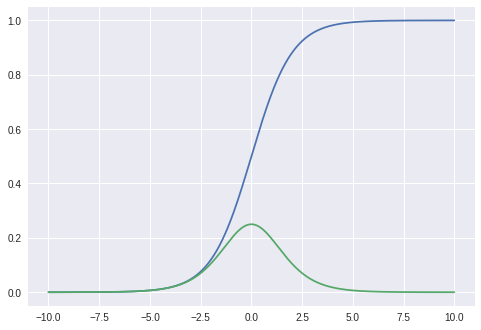

In [4]:
sigmoid = lambda x: 1/(1+np.exp(-x))
sigmoid_prime = lambda x: sigmoid(x)*(1-sigmoid(x))
xx = np.linspace(-10, 10, 1000)
plt.plot(xx, sigmoid(xx))
plt.plot(xx, sigmoid_prime(xx))
plt.show()

## 교차 엔트로피 오차 함수 (Cross-Entropy Cost Function)

이러한 수렴 속도 문제를 해결하는 방법의 하나는 오차 제곱합 형태가 아닌 교차 엔트로피(Cross-Entropy) 형태의 오차함수를 사용하는 것이다.


$$
\begin{eqnarray} 
  C = -\frac{1}{n} \sum_x \left[y \log z + (1-y) \log (1-z) \right],
\end{eqnarray}
$$


미분값은 다음과 같다.

$$
\begin{eqnarray}
  \frac{\partial C}{\partial w_j} & = & -\frac{1}{n} \sum_x \left(
    \frac{y }{z} -\frac{(1-y)}{1-z} \right)
  \frac{\partial z}{\partial w_j} \\
 & = & -\frac{1}{n} \sum_x \left( 
    \frac{y}{\sigma(a)} 
    -\frac{(1-y)}{1-\sigma(a)} \right)\sigma'(a) x_j \\
 & = &
  \frac{1}{n}
  \sum_x \frac{\sigma'(a) x_j}{\sigma(a) (1-\sigma(a))}
  (\sigma(a)-y) \\
 & = & \frac{1}{n} \sum_x x_j(\sigma(a)-y) \\ 
 & = & \frac{1}{n} \sum_x (z-y) x_j\\ \\
\frac{\partial C}{\partial b} &=& \frac{1}{n} \sum_x (z-y)
\end{eqnarray}
$$

이 식에서 보다시피 기울기(gradient)가 예측 오차(prediction error) $z-y$에 비례하기 때문에

 * 오차가 크면 수렴 속도가 빠르고
 * 오차가 적으면 속도가 감소하여 발산을 방지한다.

## Keras 에서 교차 엔트로피 사용

Keras에서는 ``compile`` 메서드의 ``loss`` 인수를 설정하여 교차 엔트로피를 포함한 다양한 오차 함수를 사용할 수 있다.
``loss`` 인수에서 설정 가능한 값 중 몇 가지를 예를 들면 다음과 같다.

* ``mean_squared_error``
* ``mean_squared_logarithmic_error``
* ``mean_absolute_error``
* ``mean_absolute_percentage_error``
* ``binary_crossentropy``
* ``categorical_crossentropy``


In [5]:
from keras.datasets import mnist
from keras.utils import np_utils

(X_train0, y_train0), (X_test0, y_test0) = mnist.load_data()
X_train = X_train0.reshape(60000, 784).astype('float32')/255.0
X_test = X_test0.reshape(10000, 784).astype('float32')/255.0
Y_train = np_utils.to_categorical(y_train0, 10)
Y_test = np_utils.to_categorical(y_test0, 10)

Using TensorFlow backend.


11100160/11490434 [===========================>..] - ETA: 0s

In [6]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

In [7]:
np.random.seed(0)
model0 = Sequential()
model0.add(Dense(15, input_dim=784, activation="sigmoid"))
model0.add(Dense(10, activation="sigmoid"))
model0.compile(optimizer=SGD(lr=0.2), loss='mean_squared_error', metrics=["accuracy"])

In [8]:
%%time
hist0 = model0.fit(X_train, Y_train, epochs=30, batch_size=100, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 1min 10s, sys: 7.42 s, total: 1min 18s
Wall time: 38.4 s


In [9]:
np.random.seed(0)
model1 = Sequential()
model1.add(Dense(15, input_dim=784, activation="sigmoid"))
model1.add(Dense(10, activation="sigmoid"))
model1.compile(optimizer=SGD(lr=0.2), loss='categorical_crossentropy', metrics=["accuracy"])

In [10]:
%%time
hist1 = model1.fit(X_train, Y_train, epochs=30, batch_size=100, validation_data=(X_test, Y_test), verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 1s - loss: 1.2076 - acc: 0.7212 - val_loss: 0.5731 - val_acc: 0.8793
Epoch 2/30
60000/60000 [==============================] - 1s - loss: 0.4628 - acc: 0.8901 - val_loss: 0.3726 - val_acc: 0.9082
Epoch 3/30
60000/60000 [==============================] - 1s - loss: 0.3498 - acc: 0.9080 - val_loss: 0.3155 - val_acc: 0.9151
Epoch 4/30
60000/60000 [==============================] - 1s - loss: 0.3066 - acc: 0.9170 - val_loss: 0.2869 - val_acc: 0.9210
Epoch 5/30
60000/60000 [==============================] - 1s - loss: 0.2821 - acc: 0.9219 - val_loss: 0.2716 - val_acc: 0.9230
Epoch 6/30
60000/60000 [==============================] - 1s - loss: 0.2653 - acc: 0.9259 - val_loss: 0.2613 - val_acc: 0.9256
Epoch 7/30
60000/60000 [==============================] - 1s - loss: 0.2525 - acc: 0.9285 - val_loss: 0.2491 - val_acc: 0.9288
Epoch 8/30
60000/60000 [==============================] - 1s 

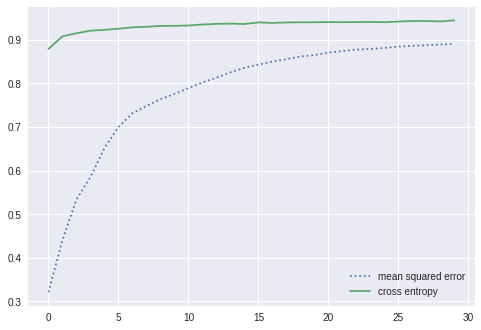

In [11]:
plt.plot(hist0.history['val_acc'], ls=":", label="mean squared error")
plt.plot(hist1.history['val_acc'], label="cross entropy")
plt.legend()
plt.show()

## Hyper-Tangent Activation and Rectified Linear Unit (ReLu) Activation

activation 함수로는 로지스틱 함수 이외에도 하이퍼 탄젠트 및 ReLu 함수를 사용할 수도 있다.

하이퍼탄젠트 함수는 음수 값을 가질 수 있으며 로지스틱 함수보다 일반적으로 수렴 속도가 빠르다.

$$
\begin{eqnarray}
 \tanh(w \cdot x+b), 
\end{eqnarray}
$$


$$
\begin{eqnarray}
  \tanh(a) \equiv \frac{e^a-e^{-a}}{e^a+e^{-a}}.
\end{eqnarray}
$$




$$
\begin{eqnarray} 
  \sigma(a) = \frac{1+\tanh(a/2)}{2},
\end{eqnarray}
$$



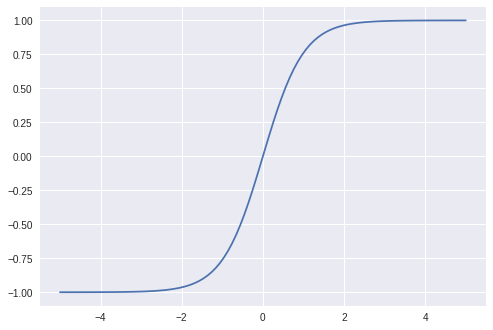

In [12]:
z = np.linspace(-5, 5, 100)
a = np.tanh(z)
plt.plot(z, a)
plt.show()

Rectified Linear Unit (ReLu) Activation 함수는 무한대 크기의 activation 값이 가능하며 가중치총합 $a$가 큰 경우에도 기울기(gradient)가 0 이되며 사라지지 않는다는 장점이 있다. 이 함수는 CNN과 같이 레이어의 수가 많은 경우에 유용하게 사용된다.

$$
\begin{eqnarray}
  \max(0, w^T x+b).
\end{eqnarray}
$$

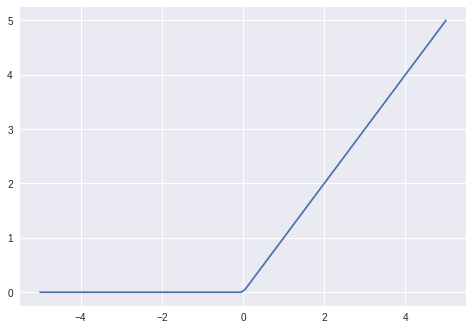

In [13]:
z = np.linspace(-5, 5, 100)
a = np.maximum(z, 0)
plt.plot(z, a)
plt.show()

In [14]:
np.random.seed(0)
model2 = Sequential()
model2.add(Dense(15, input_dim=784, activation="tanh"))
model2.add(Dense(10, activation="sigmoid"))
model2.compile(optimizer=SGD(lr=0.2), loss='categorical_crossentropy', metrics=["accuracy"])

In [15]:
%%time
hist2 = model2.fit(X_train, Y_train, epochs=30, batch_size=100, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 1min 11s, sys: 6.36 s, total: 1min 17s
Wall time: 45.3 s


In [16]:
np.random.seed(0)
model3 = Sequential()
model3.add(Dense(15, input_dim=784, activation="relu"))
model3.add(Dense(10, activation="sigmoid"))
model3.compile(optimizer=SGD(lr=0.2), loss='categorical_crossentropy', metrics=["accuracy"])

In [17]:
%%time
hist3 = model3.fit(X_train, Y_train, epochs=30, batch_size=100, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 1min 13s, sys: 6.57 s, total: 1min 19s
Wall time: 47.2 s


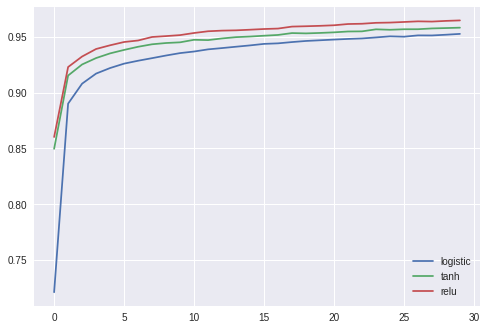

In [18]:
plt.plot(hist1.history['acc'], label="logistic")
plt.plot(hist2.history['acc'], label="tanh")
plt.plot(hist3.history['acc'], label="relu")
plt.legend()
plt.show()

## 가중치 초기화 (Weight initialization)

뉴런에 대한 입력의 수 $n_{in}$가 증가하면 가중 총합 $a$값의 표준편차도 증가한다.
 $$ \text{std}(a) \propto \sqrt{n_{in}} $$
 
예를 들어 입력이 1000개, 그 중 절반이 1이면 표준편차는 약 22.4 이 된다.
 $$ \sqrt{501} \approx 22.4 $$

<img src="https://docs.google.com/drawings/d/1PZwr7wS_3gg7bXtp16XaZCbvxj4tMrfcbCf6GJhaX_0/pub?w=608&h=153">


이렇게 표준 편차가 크면 수렴이 느려지기 때문에 입력 수에 따라 초기화 가중치의 표준편차를 감소하는 초기화 값 조정이 필요하다.
2010년 Xavier Glorot는 반복실험을 통해 다음과 같은 폭을 가진 유니폼 분포를 추천하였다.

$$w \sim \text{uniform}(-\text{limit},\text{limit}) $$

$$\text{limit} = \sqrt{6(n_{\text{in}} + n_{\text{out}})}$$

이러한 분포를 가지는 가중치 초기화는 Keras에서 ``glorot_uniform``라는 이름으로 구현되어있다.

In [19]:
np.random.seed(0)
model4 = Sequential()
model4.add(Dense(100, kernel_initializer="normal", activation="sigmoid", input_dim=784))
model4.add(Dense(10, kernel_initializer="normal", activation="sigmoid"))
model4.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=["accuracy"])

In [20]:
%%time
hist4 = model4.fit(X_train, Y_train, epochs=10, batch_size=10, verbose=0)

CPU times: user 3min 37s, sys: 20.9 s, total: 3min 58s
Wall time: 2min 16s


In [21]:
np.random.seed(0)
model5 = Sequential()
model5.add(Dense(100, input_dim=784, activation="sigmoid", kernel_initializer="glorot_uniform"))
model5.add(Dense(10, activation="sigmoid", kernel_initializer="glorot_uniform"))
model5.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=["accuracy"])

In [22]:
%%time
hist5 = model5.fit(X_train, Y_train, epochs=10, batch_size=10, verbose=0)

CPU times: user 3min 33s, sys: 20.8 s, total: 3min 54s
Wall time: 2min 12s


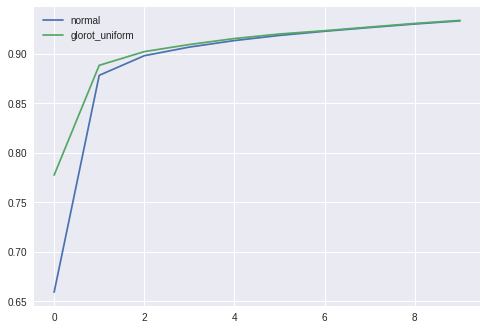

In [23]:
plt.plot(hist4.history['acc'], label="normal")
plt.plot(hist5.history['acc'], label="glorot_uniform")
plt.legend()
plt.show()

## 과최적화 문제

신경망 모형은 파라미터의 수가 다른 모형에 비해 많다. 이렇게 파라미터의 수가 많으면 과최적화 발생 가능성이 증가한다. 즉, 정확도가 나아지지 않거나 나빠져도 오차 함수는 계속 감소하는 현상이 발생한다.

In [24]:
np.random.seed(0)
model6 = Sequential()
model6.add(Dense(30, input_dim=784, activation="sigmoid"))
model6.add(Dense(10, activation="sigmoid"))
model6.compile(optimizer=SGD(lr=0.5), loss='categorical_crossentropy', metrics=["accuracy"])

In [25]:
%%time
hist6 = model6.fit(X_train, Y_train, epochs=30, batch_size=10, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 11min 11s, sys: 59.2 s, total: 12min 10s
Wall time: 6min 40s


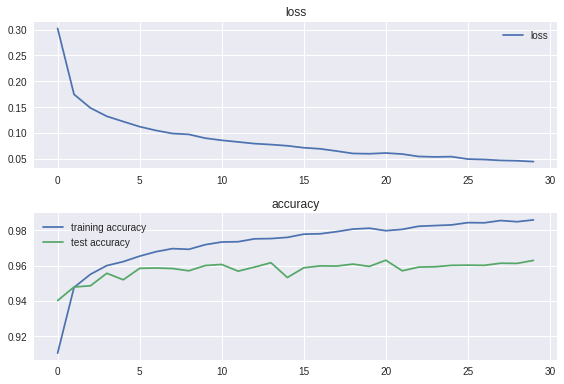

In [26]:
plt.subplot(211)
plt.plot(hist6.history['loss'], label="loss")
plt.legend()
plt.title("loss")
plt.subplot(212)
plt.plot(hist6.history['acc'], label="training accuracy")
plt.plot(hist6.history['val_acc'], label="test accuracy")
plt.legend()
plt.title("accuracy")
plt.tight_layout()
plt.show()

## L2 정규화

이러한 과최적화를 방지하기 위해서는 오차 함수에 다음과 같이 정규화 항목을 추가하여야 한다.

$$
\begin{eqnarray} C = -\frac{1}{n} \sum_{j} \left[ y_j \log z^L_j+(1-y_j) \log
(1-z^L_j)\right] + \frac{\lambda}{2n} \sum_i w_i^2
\end{eqnarray}
$$

또는 

$$
\begin{eqnarray}  C = C_0 + \frac{\lambda}{2n}
\sum_i w_i^2,
\end{eqnarray}
$$

$$
\begin{eqnarray} 
  \frac{\partial C}{\partial w} & = & \frac{\partial C_0}{\partial w} + \frac{\lambda}{n} w \\ 
  \frac{\partial C}{\partial b} & = & \frac{\partial C_0}{\partial b}
\end{eqnarray}
$$

$$
\begin{eqnarray} 
  w & \rightarrow & w-\eta \frac{\partial C_0}{\partial w}-\frac{\eta \lambda}{n} w \\ 
  & = & \left(1-\frac{\eta \lambda}{n}\right) w -\eta \frac{\partial  C_0}{\partial w}
\end{eqnarray}
$$

## L1 정규화

L2 정규화 대신 다음과 같은 L1 정규화를 사용할 수도 있다.

$$
\begin{eqnarray} C = -\frac{1}{n} \sum_{j} \left[ y_j \log z^L_j+(1-y_j) \log
(1-z^L_j)\right] + \frac{\lambda}{2n} \sum_i \| w_i \|
\end{eqnarray}
$$

$$
\begin{eqnarray}  
\frac{\partial C}{\partial w} = \frac{\partial C_0}{\partial w} + \frac{\lambda}{n} \, {\rm sgn}(w)
\end{eqnarray}
$$

$$
\begin{eqnarray}  
w \rightarrow w' = w-\frac{\eta \lambda}{n} \mbox{sgn}(w) - \eta \frac{\partial     C_0}{\partial w}
\end{eqnarray}
$$

In [27]:
from keras import regularizers

np.random.seed(0)
model7 = Sequential()
model7.add(Dense(30, input_dim=784, activation="sigmoid", kernel_regularizer=regularizers.l2(0.001)))
model7.add(Dense(10, activation="sigmoid"))
model7.compile(optimizer=SGD(lr=0.5), loss='categorical_crossentropy', metrics=["accuracy"])

In [28]:
%%time
hist7 = model7.fit(X_train, Y_train, epochs=30, batch_size=10, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 11min 47s, sys: 1min 5s, total: 12min 52s
Wall time: 6min 54s


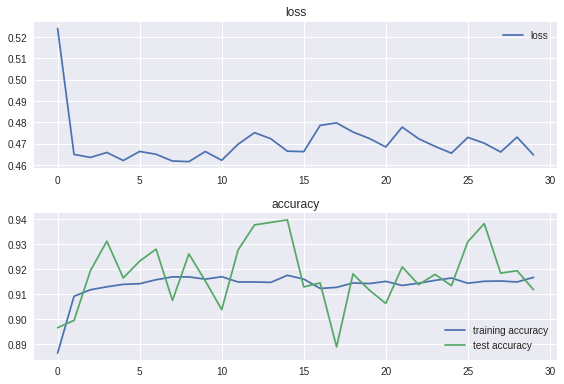

In [29]:
plt.subplot(211)
plt.plot(hist7.history['loss'], label="loss")
plt.legend()
plt.title("loss")
plt.subplot(212)
plt.plot(hist7.history['acc'], label="training accuracy")
plt.plot(hist7.history['val_acc'], label="test accuracy")
plt.legend()
plt.title("accuracy")
plt.tight_layout()
plt.show()

## Dropout 정규화

Dropout 정규화 방법은 epoch 마다 임의의 hidden layer neurons $100p$%(보통 절반)를 dropout 하여 최적화 과정에 포함하지 않는 방법이다. 이 방법을 사용하면 가중치 값들 값들이 동시에 움직이는 것(co-adaptations) 방지하며 모형 averaging 효과를 가져다 준다.
<img src="http://neuralnetworksanddeeplearning.com/images/tikz31.png">

가중치 갱신이 끝나고 테스트 시점에는 가중치에 $p$를 곱하여 스케일링한다.

<img src="https://datascienceschool.net/upfiles/8e5177d1e7dd46a69d5b316ee8748e00.png">

In [30]:
from keras.layers import Dropout

np.random.seed(0)
model8 = Sequential()
model8.add(Dense(30, input_dim=784, activation="sigmoid"))
model8.add(Dropout(0.5))
model8.add(Dense(10, activation="sigmoid"))
model8.compile(optimizer=SGD(lr=0.5), loss='categorical_crossentropy', metrics=["accuracy"])

In [31]:
%%time
hist8 = model8.fit(X_train, Y_train, epochs=30, batch_size=10, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 11min 49s, sys: 1min 2s, total: 12min 51s
Wall time: 7min 7s


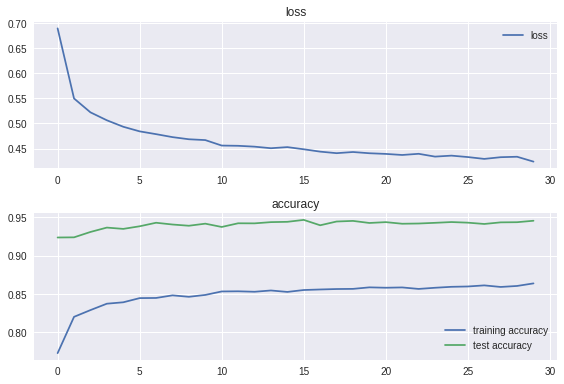

In [32]:
plt.subplot(211)
plt.plot(hist8.history['loss'], label="loss")
plt.legend()
plt.title("loss")
plt.subplot(212)
plt.plot(hist8.history['acc'], label="training accuracy")
plt.plot(hist8.history['val_acc'], label="test accuracy")
plt.legend()
plt.title("accuracy")
plt.tight_layout()
plt.show()

## 소프트맥스 출력 

소프트맥스(softmax) 함수는 입력과 출력이 다변수(multiple variable) 인 함수이다. 최고 출력의 위치를 변화하지 않으면서 츨력의 합이 1이 되도록 조정하기 때문에 출력에 확률론적 의미를 부여할 수 있다. 보통 신경망의 최종 출력단에 적용한다.



$$
\begin{eqnarray} 
  y^L_j = \frac{e^{a^L_j}}{\sum_k e^{a^L_k}},
\end{eqnarray}
$$



$$
\begin{eqnarray}
  \sum_j y^L_j & = & \frac{\sum_j e^{a^L_j}}{\sum_k e^{a^L_k}} = 1
\end{eqnarray}
$$



<img src="https://www.tensorflow.org/versions/master/images/softmax-regression-scalargraph.png" style="width:60%;">


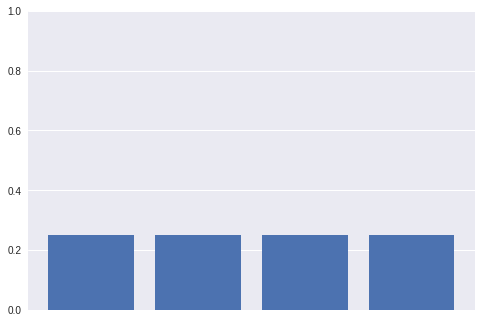

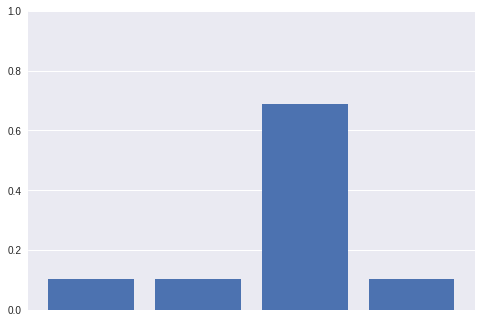

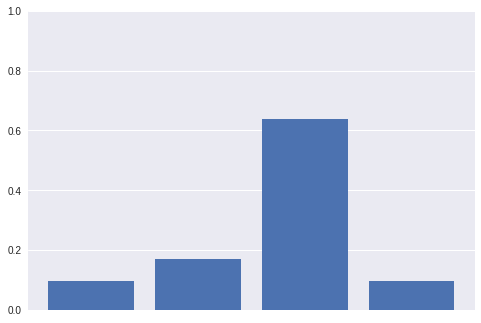

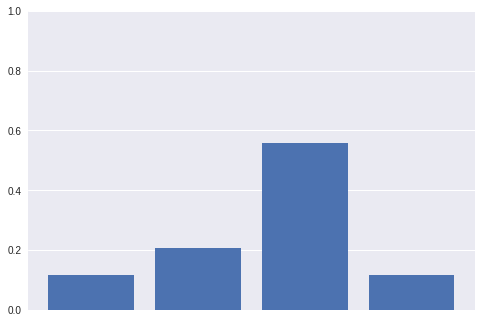

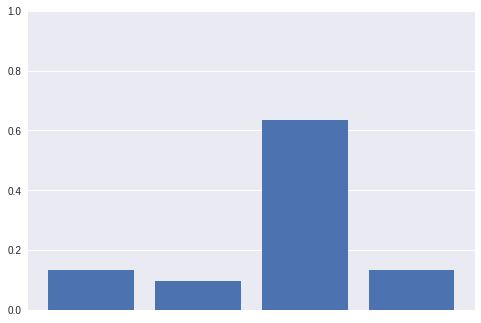

In [33]:
from ipywidgets import interactive
from IPython.display import Audio, display

def softmax_plot(z1=0, z2=0, z3=0, z4=0):
    exps = np.array([np.exp(z1), np.exp(z2), np.exp(z3), np.exp(z4)])
    exp_sum = exps.sum()
    plt.bar(range(len(exps)), exps/exp_sum, align="center")
    plt.ylim(0, 1)
    plt.xticks([])
    
v = interactive(softmax_plot, z1=(-3, 5, 0.01), z2=(-3, 5, 0.01), z3=(-3, 5, 0.01), z4=(-3, 5, 0.01))
display(v)

In [34]:
np.random.seed(0)
model9 = Sequential()
model9.add(Dense(15, input_dim=784, activation="sigmoid", kernel_initializer="glorot_uniform"))
model9.add(Dense(10, activation="softmax", kernel_initializer="glorot_uniform"))
model9.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=["accuracy"])

In [35]:
%%time
hist9 = model9.fit(X_train, Y_train, epochs=10, batch_size=10, verbose=0)

CPU times: user 3min 28s, sys: 20.8 s, total: 3min 49s
Wall time: 2min 4s


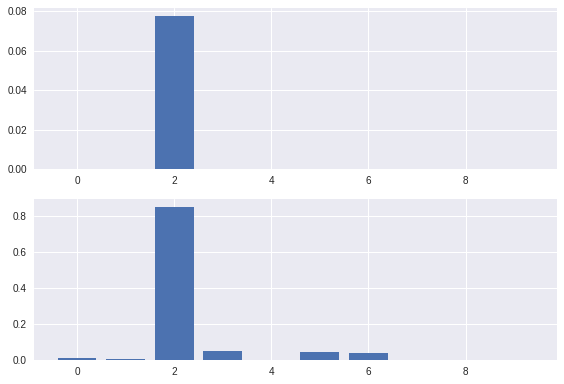

In [36]:
k = 1
y8 = model8.predict(X_test[k:k+1, :])[0]
y9 = model9.predict(X_test[k:k+1, :])[0]

plt.subplot(211)
plt.bar(range(len(y8)), y8, align="center")
plt.subplot(212)
plt.bar(range(len(y9)), y9, align="center")
plt.tight_layout()
plt.show()

# Convolutional Neural Network 기초

## CNN

* 이미지 분류를 위한 특별한 구조의 Deep Neural Network

 * local receptive fields
 * shared weights
 * pooling

## Local Receptive Field


* Input Layer의 일부 Input에 대해서만 다음 Hidden Layer로 weight 연결
 * 예: 28x28 Input Layer에서 5x5 영역에 대해서만 weight 연결 
 * => 다음 Hidden Layer의 크기는 (28-5+1)x(28-5+1) = 24x24
 * Sparse Connectivity
 

<img src="http://neuralnetworksanddeeplearning.com/images/tikz44.png">
<img src="http://neuralnetworksanddeeplearning.com/images/tikz45.png">


* http://cs231n.github.io/assets/conv-demo/index.html

## Shared weights and biases

* 모든 연결에 대해 공통 weight & bias 계수 사용
 * 위 예에서 parameter의 수는 26개 (5x5+1)
 
$$
\begin{eqnarray} 
  \sigma\left(b + \sum_{l=0}^4 \sum_{m=0}^4  w_{l,m} a_{j+l, k+m} \right).
\end{eqnarray}
$$


* 이 연산은 2-D image filter의 convolution연산과 동일 
 * => Convolution NN
 * 공통 weight: image kernel, image filter

## Image Filter

<img src="http://i.stack.imgur.com/GvsBA.jpg">

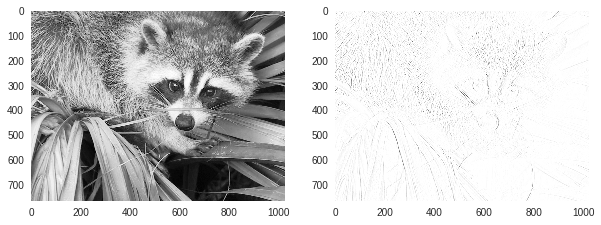

In [46]:
import scipy.ndimage
import scipy as sp
img = 255 - sp.misc.face(gray=True).astype(float)
k = np.zeros((2,2))
k[:,0] = -1; k[:,1] = 1
img2 = np.maximum(0, sp.ndimage.filters.convolve(img, k))
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(img)
plt.grid(False)
plt.subplot(122)
plt.imshow(img2)
plt.grid(False)

## Feature Map

* 만약 weight가 특정 image patter에 대해 a=1인 출력을 내도록 training 되었다면 
 * hidden layer는 feature가 존재하는 위치를 표시
 * => feature map
* 여기에서의 feature는 input data를 의미하는 것이 아니라 image 분류에 사용되는 input data의 특정한 pattern을 뜻함


<img src="http://www.kdnuggets.com/wp-content/uploads/computer-vision-filters.jpg">



## Multiple Feature Maps

* 하나의 공통 weight set은 한 종류의 image feature만 발견 가능
* 복수의 feature map (weight set) 필요

<img src="http://neuralnetworksanddeeplearning.com/images/tikz46.png"> 


* MNIST digit image 에 대해 training이 완료된 20개 feature map의 예

<img src="http://neuralnetworksanddeeplearning.com/images/net_full_layer_0.png" style="width:50%;"> 

## Max Pooling Layer

* 영역내에서 가장 최대값 출력
 * 영역내에 feature가 존재하는지의 여부
 * 전체 영역이 축소 
 
<img src="http://cs231n.github.io/assets/cnn/maxpool.jpeg" style="width:50%;"> 



<img src="http://neuralnetworksanddeeplearning.com/images/tikz48.png">

## L2 pooling

* maximum 값 대신에 영역내의 값의 sum of square 사용

## Output Layer

* softmax 

<img src="http://neuralnetworksanddeeplearning.com/images/tikz49.png">

## Demo

* http://cs.stanford.edu/people/karpathy/convnetjs/demo/cifar10.html